pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


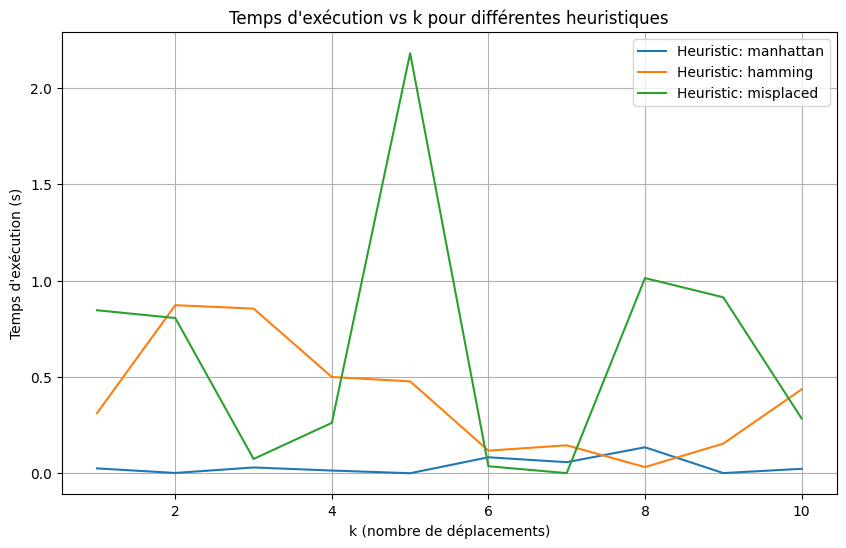

In [1]:
# Importation des bibliothèques nécessaires
import pygame
import random
import heapq
import time
import matplotlib.pyplot as plt
import pandas as pd

# Initialisation de Pygame
pygame.init()

# Dimensions par défaut
TILE_SIZE = 100
MARGIN = 50
WIDTH, HEIGHT = 0, 0
WINDOW = None

# Couleurs
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GREY = (200, 200, 200)
BLUE = (0, 102, 204)
RED = (204, 0, 0)
GREEN = (0, 255, 0)

# --- Fonctions Utilitaires ---
def initialize_window(n):
    global WIDTH, HEIGHT, WINDOW
    WIDTH = HEIGHT = TILE_SIZE * n + MARGIN * 2
    WINDOW = pygame.display.set_mode((WIDTH, HEIGHT))
    pygame.display.set_caption(f"{n * n - 1}-Puzzle")

def generate_puzzle(n):
    puzzle = list(range(1, n * n)) + [0]
    while True:
        random.shuffle(puzzle)
        if is_solvable(puzzle, n):
            break
    return puzzle

def is_solvable(puzzle, n):
    inversions = 0
    for i in range(len(puzzle)):
        for j in range(i + 1, len(puzzle)):
            if puzzle[i] != 0 and puzzle[j] != 0 and puzzle[i] > puzzle[j]:
                inversions += 1
    if n % 2 == 1:
        return inversions % 2 == 0
    else:
        blank_row = puzzle.index(0) // n
        return (inversions + blank_row) % 2 == 0

def manhattan_distance(puzzle, n):
    distance = 0
    for index, value in enumerate(puzzle):
        if value != 0:
            target_x, target_y = divmod(value - 1, n)
            current_x, current_y = divmod(index, n)
            distance += abs(target_x - current_x) + abs(target_y - current_y)
    return distance

def hamming_distance(puzzle, n):
    distance = 0
    for index, value in enumerate(puzzle):
        if value != 0 and value != index + 1:
            distance += 1
    return distance

def misplaced_tiles(puzzle, n):
    return hamming_distance(puzzle, n)

# --- Fonction A* ---
def a_star_solver(initial_puzzle, n, heuristic):
    start_time = time.time()

    start_state = tuple(initial_puzzle)
    target_state = tuple(range(1, n * n)) + (0,)

    open_set = []
    heapq.heappush(open_set, (0, start_state, start_state.index(0), 0, None))
    closed_set = set()
    parent_map = {}

    while open_set:
        _, current_state, blank_pos, g_score, parent = heapq.heappop(open_set)

        if current_state in closed_set:
            continue

        closed_set.add(current_state)
        parent_map[current_state] = parent

        if current_state == target_state:
            path = []
            while current_state:
                path.append(current_state)
                current_state = parent_map[current_state]
            end_time = time.time()
            execution_time = end_time - start_time
            return path[::-1], len(path), execution_time, "Réussite"

        i, j = divmod(blank_pos, n)
        neighbors = [(i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1)]

        for ni, nj in neighbors:
            if 0 <= ni < n and 0 <= nj < n:
                new_blank_pos = ni * n + nj
                new_state = list(current_state)
                new_state[blank_pos], new_state[new_blank_pos] = new_state[new_blank_pos], new_state[blank_pos]
                new_state = tuple(new_state)

                if new_state not in closed_set:
                    if heuristic == 'manhattan':
                        h_score = manhattan_distance(new_state, n)
                    elif heuristic == 'hamming':
                        h_score = hamming_distance(new_state, n)
                    else:
                        h_score = misplaced_tiles(new_state, n)

                    f_score = g_score + 1 + h_score
                    heapq.heappush(open_set, (f_score, new_state, new_blank_pos, g_score + 1, current_state))

    end_time = time.time()
    execution_time = end_time - start_time
    return None, 0, execution_time, "Échec"

# --- Fonction de visualisation ---
def plot_results(df):
    plt.figure(figsize=(10, 6))
    for heuristic in df['Heuristic'].unique():
        subset = df[df['Heuristic'] == heuristic]
        plt.plot(subset['k'], subset['Execution Time'], label=f'Heuristic: {heuristic}')
    plt.title("Temps d'exécution vs k pour différentes heuristiques")
    plt.xlabel("k (nombre de déplacements)")
    plt.ylabel("Temps d'exécution (s)")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Tester différentes configurations et exportation ---
def experiment():
    heuristics = ['manhattan', 'hamming', 'misplaced']
    results = []

    for heuristic in heuristics:
        for k in range(1, 11):  # Tester pour différentes valeurs de k
            puzzle = generate_puzzle(3)  # Générer le puzzle 3x3
            path, moves, execution_time, status = a_star_solver(puzzle, 3, heuristic)
            results.append([k, execution_time, moves, status, heuristic])

    # Sauvegarder les résultats dans un DataFrame et exporter
    df = pd.DataFrame(results, columns=["k", "Execution Time", "Moves", "Status", "Heuristic"])
    df.to_csv("experiment_results.csv", index=False)

    # Visualisation
    plot_results(df)

experiment()
